In [1]:
import sys
sys.path.append('../data_generated_library')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import credit_card_data
import pickle
import torch.nn as nn
import torch
import torch.nn.functional as F
# from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## data generation

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
# train_data = pickle.load(open('../data_1/train_data_HMM','rb'))
# train_label= pickle.load(open('../data_1/train_label_HMM','rb'))
# test_data = pickle.load(open('../data_1/test_data_HMM','rb'))
# test_label = pickle.load(open('../data_1/test_label_HMM','rb'))

In [3]:
train_data = pickle.load(open('../data_2/train_data','rb'))
train_label= pickle.load(open('../data_2/train_label','rb'))
test_data = pickle.load(open('../data_2/test_data','rb'))
test_label = pickle.load(open('../data_2/test_label','rb'))

In [16]:
window_size = 24

In [10]:
train_data = torch.tensor(train_data,dtype = torch.float)
test_data = torch.tensor(test_data,dtype = torch.float)
train_label = torch.tensor(train_label,dtype = torch.float)
test_label = torch.tensor(test_label,dtype = torch.float)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy 

In [15]:
train_data.shape

torch.Size([8640, 24])

## ANN

In [17]:
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ANN, self).__init__()
        hidden_dim = input_dim // 2
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, input_data):
        l1 = self.linear1(input_data)
        l2 = self.linear2(l1)
        y_pred = nn.Sigmoid()(l2)
        return y_pred

In [18]:
ann_model = ANN(input_dim=window_size, output_dim=1)
ann_model.to(device)

learning_rate = 0.01
loss_fn = torch.nn.BCELoss(size_average=False)
optimiser = torch.optim.Adam(ann_model.parameters(), lr=learning_rate)

/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [20]:
num_epochs = 10
batch_size = 128

#ann_writer = SummaryWriter()
for t in range(num_epochs):
    # shuffle data
    idx = np.random.permutation(len(train_data))
    train_data = train_data[idx]
    train_label = train_label[idx]
    total_loss = 0
    for i in range(len(train_data)//batch_size):
        optimiser.zero_grad()
        batch_data = train_data[i*batch_size:(i+1)*batch_size]
        batch_label = train_label[i*batch_size:(i+1)*batch_size]
        y_pred = ann_model(batch_data)
        weight = 4 * (batch_label == 1).float() + torch.ones(batch_size, device=device)
        loss = torch.nn.BCELoss(weight=weight)(y_pred, batch_label)
        #ann_writer.add_scalar('ANN loss', loss, t * len(train_data)//batch_size +i)
        total_loss += loss
        loss.backward()
        optimiser.step()
    print("epoch {:d}: {}".format(t, total_loss/(len(train_data)//batch_size)))

/usr/local/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


epoch 0: 0.6050939559936523
epoch 1: 0.5969028472900391
epoch 2: 0.5991812944412231
epoch 3: 0.5945814251899719
epoch 4: 0.5949675440788269
epoch 5: 0.5921769738197327
epoch 6: 0.5933834314346313
epoch 7: 0.5940915942192078
epoch 8: 0.5918219089508057
epoch 9: 0.5939525365829468


## LSTM

In [21]:
class LSTM(nn.Module):
    def __init__(self, output_dim, bidirectional=False):
        super(LSTM, self).__init__()
        self.input_dim = 1
        self.hidden_dim = 3
        self.num_layers = 2
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, bidirectional=bidirectional)
        self.linear = nn.Linear((bidirectional+1)*self.hidden_dim, output_dim)
    
    def forward(self, input_data):
        lstm_out, hidden = self.lstm(input_data.view(input_data.size()[0], input_data.size()[1], -1))
        linear = self.linear(lstm_out[-1])
        y_pred = nn.Sigmoid()(linear)
        return y_pred

In [22]:
lstm_model = LSTM(output_dim=1)
lstm_model.to(device)

learning_rate = 0.01
loss_fn = torch.nn.BCELoss(size_average=False)
optimiser = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [23]:
num_epochs = 10
batch_size = 128

#lstm_writer = SummaryWriter()
for t in range(num_epochs):
    # shuffle data
    idx = np.random.permutation(len(train_data))
    train_data = train_data[idx]
    train_label = train_label[idx]
    total_loss = 0
    for i in range(len(train_data)//batch_size):
        optimiser.zero_grad()
        batch_data = train_data[i*batch_size:(i+1)*batch_size].permute(1,0)
        batch_label = train_label[i*batch_size:(i+1)*batch_size]
        y_pred = lstm_model(batch_data)
        weight = 4 * (batch_label == 1).float() + torch.ones(batch_size, device=device)
        loss = torch.nn.BCELoss(weight=weight)(y_pred, batch_label)
        #lstm_writer.add_scalar('LSTM loss', loss, t * len(train_data)//batch_size +i)
        total_loss += loss
        loss.backward()
        optimiser.step()
    print("epoch {:d}: {}".format(t, total_loss/(len(train_data)//batch_size)))

/usr/local/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


epoch 0: 0.988135039806366
epoch 1: 0.6471506357192993
epoch 2: 0.5841115713119507
epoch 3: 0.5782243609428406
epoch 4: 0.5557475090026855
epoch 5: 0.5502058863639832
epoch 6: 0.5422110557556152
epoch 7: 0.5449448227882385
epoch 8: 0.5430991053581238
epoch 9: 0.5447702407836914


## CNN

In [24]:
class CNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNN, self).__init__()
        kernel_size = 3
        self.input_dim = input_dim
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=3, kernel_size=kernel_size)
        self.conv2 = torch.nn.Conv1d(in_channels=3, out_channels=3, kernel_size=kernel_size)
        self.linear1 = nn.Linear((input_dim-2*(kernel_size-1))*3, 10)
        self.linear2 = nn.Linear(10, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input_data):
        conv_out1 = self.conv1(input_data.view(input_data.size()[0], 1, input_data.size()[1]))
        conv_out1 = nn.ReLU()(conv_out1)
        conv_out2 = self.conv2(conv_out1)
        conv_out2 = nn.ReLU()(conv_out2)
        linear1 = self.linear1(conv_out2.view(conv_out2.size()[0], -1))
        linear1 = nn.ReLU()(linear1)
        linear2 = self.linear2(linear1)
        y_pred = self.sigmoid(linear2)
        return y_pred

In [25]:
cnn_model = CNN(input_dim=window_size, output_dim=1)
cnn_model.to(device)

learning_rate = 0.01
loss_fn = torch.nn.BCELoss(size_average=False)
optimiser = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [26]:
num_epochs = 10
batch_size = 128

#cnn_writer = SummaryWriter()
for t in range(num_epochs):
    # shuffle data
    idx = np.random.permutation(len(train_data))
    train_data = train_data[idx]
    train_label = train_label[idx]
    total_loss = 0
    for i in range(len(train_data)//batch_size):
        optimiser.zero_grad()
        batch_data = train_data[i*batch_size:(i+1)*batch_size]
        batch_label = train_label[i*batch_size:(i+1)*batch_size]
        y_pred = cnn_model(batch_data)
        weight = 4 * (batch_label == 1).float() + torch.ones(batch_size, device=device)
        loss = torch.nn.BCELoss(weight=weight)(y_pred, batch_label)
        #cnn_writer.add_scalar('CNN loss', loss, t * len(train_data)//batch_size +i)
        total_loss += loss
        loss.backward()
        optimiser.step()
    print("epoch {:d}: {}".format(t, total_loss/(len(train_data)//batch_size)))

/usr/local/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


epoch 0: 0.7534032464027405
epoch 1: 0.5802819132804871
epoch 2: 0.5642803311347961
epoch 3: 0.5590586066246033
epoch 4: 0.5596926808357239
epoch 5: 0.5511071681976318
epoch 6: 0.5554407835006714
epoch 7: 0.5473907589912415
epoch 8: 0.5512919425964355
epoch 9: 0.540824294090271


## LSTM + Attention

In [50]:
## Attention Layer
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.kaiming_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim 
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)
        #print(a)
        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)

In [51]:
class LSTM_ATT(nn.Module):
    def __init__(self, batch_size, seq_len, att_dim, output_dim=3):
        super(LSTM_ATT, self).__init__()
        self.input_dim = 1
        self.hidden_dim = 4
        self.batch_size = batch_size
        self.num_layers = 2
        self.seq_len = seq_len
        self.att_dim = att_dim
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.att = Attention(self.att_dim,2)
        self.linear_2 = nn.Linear(self.att_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input):
        lstm_out, hidden = self.lstm(input.view(input.size()[0],input.size()[1],-1))#;print(lstm_out.size())
        att_out = self.att(lstm_out[-2:].permute(1,0,2))#;print(att_out.size())
        output_2 = self.linear_2(att_out)#;print(output_2.size())
        y_pred_2 = self.sigmoid(output_2)
        return y_pred_2

In [52]:
att_dim = 4
output_dim = 1
lstm_att_model = LSTM_ATT(
    batch_size=batch_size, 
    seq_len = window_size,
    att_dim = att_dim,
    output_dim=output_dim
)
lstm_att_model.to(device)

learning_rate = 0.002
loss_fn = torch.nn.BCELoss(size_average=False)
optimiser = torch.optim.Adam(lstm_att_model.parameters(), lr=learning_rate)

/usr/local/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [53]:
num_epochs = 20
batch_size = 128

#lstm_att_writer = SummaryWriter()
for t in range(num_epochs):
    # shuffle data
    idx = np.random.permutation(len(train_data))
    train_data = train_data[idx]
    train_label = train_label[idx]
    total_loss = 0
    for i in range(len(train_data)//batch_size):
        optimiser.zero_grad()
        batch_data = train_data[i*batch_size:(i+1)*batch_size].permute(1,0)
        batch_label = train_label[i*batch_size:(i+1)*batch_size]
        y_pred = lstm_att_model(batch_data)
        weight = 4 * (batch_label == 1).float() + torch.ones(batch_size, device=device)
        loss = torch.nn.BCELoss(weight=weight)(y_pred, batch_label)
        #lstm_att_writer.add_scalar('LSTM-ATT loss', loss, t * len(train_data)//batch_size +i)
        total_loss += loss
        loss.backward()
        optimiser.step()
    print("epoch {:d}: {}".format(t, total_loss/(len(train_data)//batch_size)))

/usr/local/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


epoch 0: 1.0814871788024902
epoch 1: 0.8858824968338013
epoch 2: 0.7749894261360168
epoch 3: 0.71192467212677
epoch 4: 0.6679762005805969
epoch 5: 0.6452797651290894
epoch 6: 0.6246038675308228
epoch 7: 0.60745769739151
epoch 8: 0.5958435535430908
epoch 9: 0.5850709080696106
epoch 10: 0.5758191347122192
epoch 11: 0.5741470456123352
epoch 12: 0.5712647438049316
epoch 13: 0.5594772100448608
epoch 14: 0.5561884045600891
epoch 15: 0.5548108220100403
epoch 16: 0.5500591993331909
epoch 17: 0.5465073585510254
epoch 18: 0.5456445217132568
epoch 19: 0.5437784790992737


## Save


In [31]:
for m in [ann_model,cnn_model,lstm_model,lstm_att_model]:
    torch.save(m,(str(m).split()[0][:-1])+'_2')
#     torch.save

/usr/local/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ANN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type LSTM_ATT. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/site-packages

## Measure

In [32]:
def criteria(pred, label, threshold):
    recall = []
    precision = []
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    TP += ((pred > threshold).numpy().flatten()&(label == 1).numpy()).sum()
    TN += ((pred < threshold).numpy().flatten()&(label == 0).numpy()).sum()
    FP += ((pred > threshold).numpy().flatten()&(label == 0).numpy()).sum()
    FN += ((pred < threshold).numpy().flatten()&(label == 1).numpy()).sum()
    return TP, TN, FP, FN



def plot(pred, label, func, name):
    xs = []
    ys = []
    steps = 1000
    l, r = pred.min(), pred.max()
    for i in range(steps):
        t = l + (r - l) * i / steps
        x, y = func(pred, label, t)
        xs.append(x)
        ys.append(y)
    plt.plot(xs, ys,label = name)
    plt.xlim(0,1)
    plt.ylim(0,1)
def get_pr(pred, label, func):
    xs = []
    ys = []
    steps = 1000
    l, r = pred.min(), pred.max()
    for i in range(steps):
        t = l + (r - l) * i / steps
        x, y = func(pred, label, t)
        xs.append(x)
        ys.append(y)
    return xs,ys

In [33]:
def precision_recall(pred, label, threshold):
    TP, TN, FP, FN = criteria(pred, label, threshold)
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    return recall, precision

def precision_recall_plot(pred, label, name = None):
    plot(pred, label, precision_recall, name)

In [34]:
def ROC(pred, label, threshold):
    TP, TN, FP, FN = criteria(pred, label, threshold)
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    return FPR, TPR

def ROC_plot(pred, label, name = None):
    plot(pred, label, ROC, name)

In [35]:
y_test = lstm_model(test_data.permute(1,0)).cpu()

(0.9209302325581395, 0.7021276595744681)


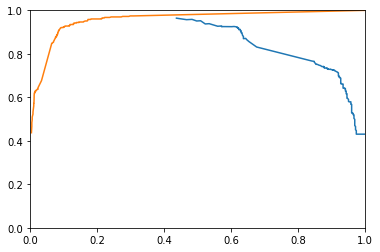

In [36]:
print(precision_recall(y_test, test_label, 0.5))
precision_recall_plot(y_test, test_label)
ROC_plot(y_test, test_label)
plt.show()

(0.9209302325581395, 0.6971830985915493)


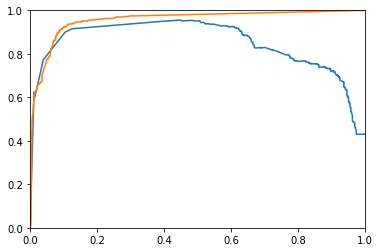

In [37]:
y_test = cnn_model(test_data).cpu()
print(precision_recall(y_test, test_label, 0.5))
precision_recall_plot(y_test, test_label)
ROC_plot(y_test, test_label)
plt.show()

(0.9093023255813953, 0.7135036496350365)


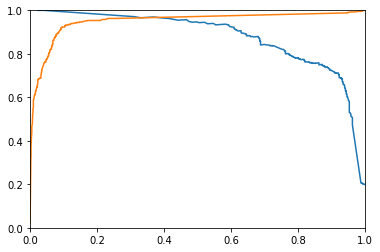

In [38]:
y_test = ann_model(test_data).cpu()
print(precision_recall(y_test, test_label, 0.5))
precision_recall_plot(y_test, test_label)
ROC_plot(y_test, test_label)
plt.show()

In [39]:
y_test = lstm_att_model(test_data.permute(1,0)).cpu()

(0.9116279069767442, 0.6735395189003437)


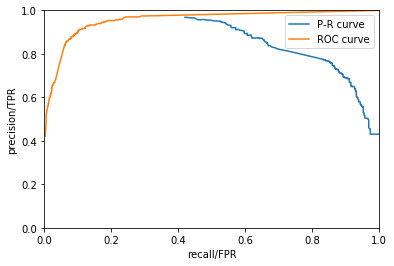

In [40]:
print(precision_recall(y_test, test_label, 0.5))
precision_recall_plot(y_test, test_label,'P-R curve')
ROC_plot(y_test, test_label,'ROC curve')
plt.xlabel('recall/FPR')
plt.ylabel('precision/TPR')
plt.legend()
plt.show()

In [54]:
y_test_lstm = lstm_model(test_data.permute(1,0)).cpu()
y_test_cnn = cnn_model(test_data).cpu()
y_test_ann = ann_model(test_data).cpu()
y_test_lstm_att = lstm_att_model(test_data.permute(1,0)).cpu()


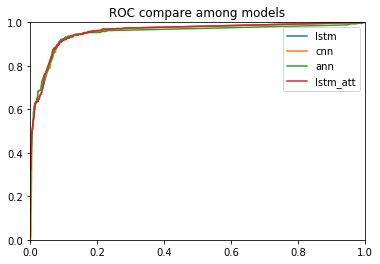

In [55]:
ROC_plot(y_test_lstm, test_label, name = 'lstm')
ROC_plot(y_test_cnn, test_label, name = 'cnn')
ROC_plot(y_test_ann, test_label, name = 'ann')
ROC_plot(y_test_lstm_att, test_label, name = 'lstm_att')
plt.legend()
plt.title('ROC compare among models')
plt.show()

In [56]:
ratio = test_label.cpu().numpy().sum()/len(test_label)

In [57]:
precision_lower_bound = []
recall_lower_bound = []
for i in range(1000):
    precision_lower_bound.append(ratio)
    recall_lower_bound.append(i*0.001)

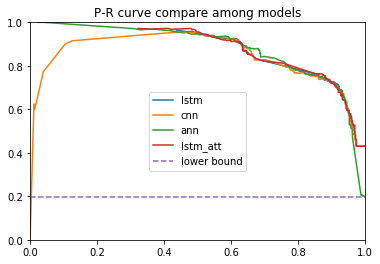

In [58]:
precision_recall_plot(y_test_lstm, test_label, name = 'lstm')
precision_recall_plot(y_test_cnn, test_label, name = 'cnn')
precision_recall_plot(y_test_ann, test_label, name = 'ann')
precision_recall_plot(y_test_lstm_att, test_label, name = 'lstm_att')
plt.plot(recall_lower_bound,precision_lower_bound,'--',label = 'lower bound')
plt.legend()
plt.title('P-R curve compare among models')
plt.show()

In [59]:
def encode(z):
    res = 0
    for i in z:
        res *= 2
        res += i
    return res

data = {}
for i in range(len(test_label)):
    x = encode(test_data[i])
    if x in data:
        data[x]['count'] += 1
        data[x]['label'] += test_label[i]
    else:
        data[x] = {'count': 1, 'label': test_label[i]}

y_pred = []
for z in test_data:
    x = encode(z)
    if x in data:
        y_pred.append(data[x]['label'] / data[x]['count'])
    else:
        y_pred.append(0)
y_pred = np.array(y_pred)

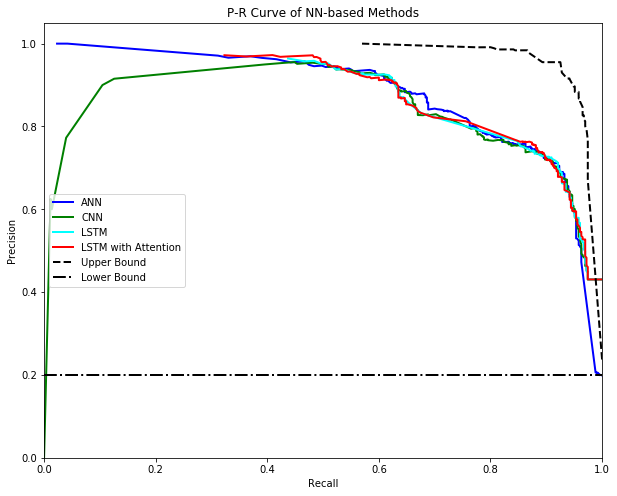

In [61]:
plt.figure(figsize = (10,8))
plt.clf()
r,p = get_pr(y_test_ann,test_label,precision_recall)
plt.plot(r,p, label='ANN', linewidth=2, color = 'blue')
r,p = get_pr(y_test_cnn,test_label,precision_recall)
plt.plot(r,p, label='CNN', linewidth=2, color = 'green')
r,p = get_pr(y_test_lstm,test_label,precision_recall)
plt.plot(r,p, label='LSTM', linewidth=2, color = 'cyan')
r,p = get_pr(y_test_lstm_att,test_label,precision_recall)
plt.plot(r,p, label='LSTM with Attention', linewidth=2, color = 'red')
f = open('upperbound_recall_2','rb')
r = pickle.load(f)
f.close()
f = open('upperbound_precision_2','rb')
p = pickle.load(f)
f.close()
plt.plot(r,p, '--', label='Upper Bound', linewidth=2, color = 'black')
plt.plot(recall_lower_bound,precision_lower_bound,'-.',label = 'Lower Bound',linewidth=2, color = 'black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('P-R Curve of NN-based Methods')
plt.legend(prop = {'size': 10},loc = 6)
plt.savefig('P-R Curve NN(Revert).jpg')

In [60]:
# import pickle
# filename = ["train_data", "train_label", "test_data", "test_label"]
# file = [train_data, train_label, test_data, test_label]
# for f,d in zip(filename,file):
# #     pass
#     save = open(f,'wb')
#     pickle.dump(d.cpu().numpy(),save)